In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import optuna.visualization as vis
from tensorflow.keras import layers, models
import optuna

In [10]:
batch_size = 32
img_height = 8
img_width = 8
train_data_dir = "C:/Users/lanzi/Desktop/TRAIN_SET CASA"
val_data_dir = "C:/Users/lanzi/Desktop/VAL_SET CASA"
test_data_dir = "C:/Users/lanzi/Desktop/TEST_SET CASA"

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_data_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size = batch_size)

print("TRAIN CLASSES:", train_ds.class_names)
print("VALIDATION CLASSES:", val_ds.class_names)
print("TEST CLASSES:", test_ds.class_names)

Found 16695 files belonging to 4 classes.
Found 9173 files belonging to 4 classes.
Found 8055 files belonging to 4 classes.
TRAIN CLASSES: ['EMPTY', 'HAND', 'HANDWITHOBJECT', 'OBJECT']
VALIDATION CLASSES: ['EMPTY', 'HAND', 'HANDWITHOBJECT', 'OBJECT']
TEST CLASSES: ['EMPTY', 'HAND', 'HANDWITHOBJECT', 'OBJECT']


In [12]:
#the normalization step in this case has been considered as a preprocessing step, but it could be also inserted in the CNN as first layer after the INPUT LAYER
#In addition, given the quite great number of training images, the data augmentation has been removed from this script. Also to fast the training process.
normalization_layer = tf.keras.layers.Rescaling(1./255)

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) 

## OPTUNA HYPERPARAMETER TUNING

In [13]:
def create_cnn_model(num_filters1, num_filters2, num_filters3, kernel_size, pool_size, dense_units, dropout_rate):
    model = models.Sequential()

    model.add(layers.Input(shape=(8, 8, 3)))

    # First Conv Layer
    model.add(layers.Conv2D(num_filters1, kernel_size, activation='relu'))
    model.add(layers.BatchNormalization())

    # Second Conv Layer
    model.add(layers.Conv2D(num_filters2, kernel_size, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=pool_size))

    # Third Conv Layer
    model.add(layers.Conv2D(num_filters3, kernel_size, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=pool_size))

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(4, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [15]:
best_test_accuracy = 0.0
best_model_path = 'best_model.keras'

def objective(trial):

    global best_test_accuracy

    num_filters1 = trial.suggest_int('num_filters1', 16, 256)
    num_filters2 = trial.suggest_int('num_filters2', 16, 256)
    num_filters3 = trial.suggest_int('num_filters3', 16, 256)
    kernel_size = trial.suggest_categorical('kernel_size', [(2, 2)])
    pool_size = trial.suggest_categorical('pool_size', [(2, 2)])
    dense_units = trial.suggest_int('dense_units', 64, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    # Create and compile the CNN model
    model = create_cnn_model(num_filters1, num_filters2, num_filters3, kernel_size, pool_size, dense_units, dropout_rate)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                              patience=2, min_lr=0.0001)

    history = model.fit(
        train_ds,
        epochs=10,
        validation_data=val_ds,
        callbacks=[reduce_lr],
        verbose=0
    )
    
    val_accuracy = history.history['val_accuracy'][-1]
    
    #if the current model has the best test accuracy, save it
    if val_accuracy > best_test_accuracy:
        best_test_accuracy = val_accuracy
        model.save(best_model_path)
        print(f"New best model saved with test accuracy: {best_test_accuracy:.4f}")
    
    return val_accuracy


def run_optimization():
    study = optuna.create_study(direction='maximize')  # Maximize validation accuracy
    study.optimize(objective, n_trials=50)  
    
    print("Best hyperparameters: ", study.best_params)
    print("Best validation accuracy: ", study.best_value)
    vis.plot_optimization_history(study).show()
    vis.plot_param_importances(study).show()
    vis.plot_slice(study).show()  

    return study  

study = run_optimization()


[I 2024-09-01 20:53:18,881] A new study created in memory with name: no-name-b6771a7a-9b4d-426c-8438-d8aa825d56b6
[I 2024-09-01 20:55:07,471] Trial 0 finished with value: 0.8940368294715881 and parameters: {'num_filters1': 205, 'num_filters2': 52, 'num_filters3': 194, 'kernel_size': (2, 2), 'pool_size': (2, 2), 'dense_units': 90, 'dropout_rate': 0.2751597344895936}. Best is trial 0 with value: 0.8940368294715881.


New best model saved with test accuracy: 0.8940


[I 2024-09-01 20:56:40,429] Trial 1 finished with value: 0.9642428755760193 and parameters: {'num_filters1': 143, 'num_filters2': 83, 'num_filters3': 159, 'kernel_size': (2, 2), 'pool_size': (2, 2), 'dense_units': 170, 'dropout_rate': 0.47148095300504445}. Best is trial 1 with value: 0.9642428755760193.


New best model saved with test accuracy: 0.9642


[I 2024-09-01 20:59:41,477] Trial 2 finished with value: 0.9463643431663513 and parameters: {'num_filters1': 226, 'num_filters2': 132, 'num_filters3': 217, 'kernel_size': (2, 2), 'pool_size': (2, 2), 'dense_units': 119, 'dropout_rate': 0.24797462083015331}. Best is trial 1 with value: 0.9642428755760193.
[I 2024-09-01 21:02:58,734] Trial 3 finished with value: 0.9514880776405334 and parameters: {'num_filters1': 192, 'num_filters2': 120, 'num_filters3': 94, 'kernel_size': (2, 2), 'pool_size': (2, 2), 'dense_units': 118, 'dropout_rate': 0.38115366994446753}. Best is trial 1 with value: 0.9642428755760193.
[I 2024-09-01 21:05:31,308] Trial 4 finished with value: 0.9622806310653687 and parameters: {'num_filters1': 217, 'num_filters2': 248, 'num_filters3': 113, 'kernel_size': (2, 2), 'pool_size': (2, 2), 'dense_units': 68, 'dropout_rate': 0.2679472890044209}. Best is trial 1 with value: 0.9642428755760193.
[I 2024-09-01 21:07:05,935] Trial 5 finished with value: 0.9919328689575195 and param

New best model saved with test accuracy: 0.9919


[I 2024-09-01 21:09:38,520] Trial 6 finished with value: 0.915294885635376 and parameters: {'num_filters1': 255, 'num_filters2': 188, 'num_filters3': 155, 'kernel_size': (2, 2), 'pool_size': (2, 2), 'dense_units': 103, 'dropout_rate': 0.47089748138437026}. Best is trial 5 with value: 0.9919328689575195.
[I 2024-09-01 21:12:15,275] Trial 7 finished with value: 0.9191104173660278 and parameters: {'num_filters1': 209, 'num_filters2': 192, 'num_filters3': 142, 'kernel_size': (2, 2), 'pool_size': (2, 2), 'dense_units': 208, 'dropout_rate': 0.19426487583133692}. Best is trial 5 with value: 0.9919328689575195.
[I 2024-09-01 21:14:35,443] Trial 8 finished with value: 0.901340901851654 and parameters: {'num_filters1': 161, 'num_filters2': 228, 'num_filters3': 110, 'kernel_size': (2, 2), 'pool_size': (2, 2), 'dense_units': 159, 'dropout_rate': 0.2653396450643633}. Best is trial 5 with value: 0.9919328689575195.
[I 2024-09-01 21:16:23,037] Trial 9 finished with value: 0.9582470059394836 and param

Best hyperparameters:  {'num_filters1': 19, 'num_filters2': 97, 'num_filters3': 211, 'kernel_size': (2, 2), 'pool_size': (2, 2), 'dense_units': 194, 'dropout_rate': 0.272467860747151}
Best validation accuracy:  0.9919328689575195


## LOAD THE SAVED MODEL, EVALUATE IT AND COMPUTE THE CONFUSION MATRIX

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

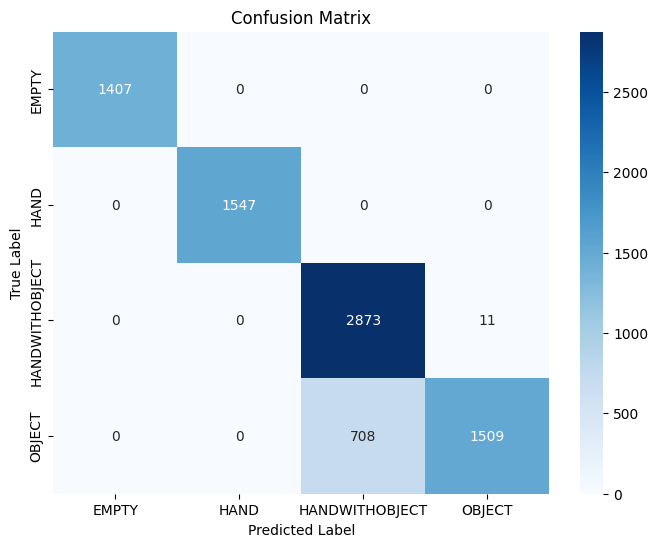

In [16]:
best_model_OP = load_model('best_model.keras')

def compute_confusion_matrix(model, test_ds):
    y_true = []
    y_pred = []

    # Iterate over the test dataset
    for images, labels in test_ds:
        predictions_proba = model.predict(images)
        pred_classes = np.argmax(predictions_proba, axis=1)
        true_classes = labels.numpy()  

        y_true.extend(true_classes)
        y_pred.extend(pred_classes)

   
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    conf_matrix = confusion_matrix(y_true, y_pred)

    return conf_matrix, y_true, y_pred

def compute_accuracy_from_confusion_matrix(conf_matrix):
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)  # Accuracy is the sum of the diagonal elements (true positives) divided by the total number of samples
    return accuracy


conf_matrix, y_true, y_pred = compute_confusion_matrix(best_model_OP, test_ds)
#print("Confusion Matrix:")
#print(conf_matrix)

accuracy = compute_accuracy_from_confusion_matrix(conf_matrix)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names for your 4 classes
class_names = ["EMPTY", "HAND", "HANDWITHOBJECT", "OBJECT"]

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, class_names)